# Reservoir curves - US
***

In [1]:
import pandas as pd
import geopandas as gpd
from datetime import datetime
from pathlib import Path
#import matplotlib.pyplot as plt
from scipy.stats import spearmanr

from lisfloodreservoirs import read_attributes, read_timeseries
from lisfloodreservoirs.utils.reservoir_curves import *

## Config

In [2]:
country = 'US'
long_name = 'United States'

path_datasets = Path('/home/chus-casado/Datos')

## Data

### ResOpsUS

In [3]:
path_resops = path_datasets / 'reservoirs' / 'ResOpsUS' / 'v2.2'

# list of selected reservoirs
res_list = pd.read_csv(path_resops / 'selection' / 'reservoirs.txt', header=None).squeeze().tolist()

# load reservoir attributes
resops_attrs = read_attributes(
    path=path_resops / 'attributes',
    reservoirs=res_list,
    index_col='GRAND_ID',
)

# load time series
resops_ts = read_timeseries(
    path=path_resops / 'time_series' / 'csv',
    reservoirs=resops_attrs.index,
    variables=['elevation', 'storage']
)
# keep only reservoirs with both elevation and storage data
resops_ts = {
    grand_id: df for grand_id, df in resops_ts.items() 
    if all(col in df.columns for col in ['elevation', 'storage'])
    }
print(f'/n Number of reservoirs with elevation and storage data: {len(resops_ts)}')
# convert storage units to hm3
for grand_id, df in resops_ts.items():
    if 'storage' in df.columns:
        df.storage *= 1e-6

  0%|          | 0/164 [00:00<?, ?it/s]

Time series for ID 55 is missing variables: {'elevation'}
Time series for ID 57 is missing variables: {'elevation'}
Time series for ID 60 is missing variables: {'elevation'}
Time series for ID 63 is missing variables: {'elevation'}
Time series for ID 131 is missing variables: {'elevation'}
Time series for ID 132 is missing variables: {'elevation'}
Time series for ID 133 is missing variables: {'elevation'}
Time series for ID 148 is missing variables: {'elevation'}
Time series for ID 180 is missing variables: {'elevation'}
Time series for ID 191 is missing variables: {'elevation'}
Time series for ID 193 is missing variables: {'elevation'}
Time series for ID 198 is missing variables: {'elevation'}
Time series for ID 214 is missing variables: {'elevation'}
Time series for ID 297 is missing variables: {'elevation'}
Time series for ID 361 is missing variables: {'elevation'}
Time series for ID 367 is missing variables: {'elevation'}
Time series for ID 372 is missing variables: {'elevation'}
T

### Global Dam Watch

In [4]:
# load GDW reservoirs in the country
path_gdw = path_datasets / 'reservoirs' / 'GDW' / 'GDW_v1_0_shp'
gdw = gpd.read_file(path_gdw / 'GDW_barriers_v1_0.shp').set_index('GRAND_ID')
gdw = gdw[gdw.COUNTRY == long_name]
print(f'GDW contains {len(gdw)} reservoirs in {long_name}')

# reduce reservoirs to those in both GDW and ResOps datasets
grand_ids = gdw.index.intersection(resops_ts.keys())
gdw = gdw.loc[grand_ids]
resops_ts = {grand_id: resops_ts[grand_id] for grand_id in grand_ids}
print(f'{len(grand_ids)} are both in GDW and ResOps datasets')

GDW contains 4862 reservoirs in United States
138 are both in GDW and ResOps datasets


## Reservoir curves

### Extract data

In [5]:
#grand_id = 169 #41 # 549 # 355
#start = datetime(2002, 1, 1)

#grand_id = 320
#start = datetime(2010, 1, 1)

grand_id = 41
start = None

# attributes
dam_hgt_m, elev_masl, cap_mcm, area_skm = gdw.loc[grand_id, ['DAM_HGT_M', 'ELEV_MASL', 'CAP_MCM', 'AREA_SKM']]
z_min = elev_masl - dam_hgt_m

# extract data 
obs = resops_ts[grand_id].loc[start:].copy()
obs.dropna(axis=0, how='any', inplace=True)
mask = (obs.elevation < z_min) | (obs.elevation > elev_masl)
print(f'{mask.sum()} observation outside the elevation range')

# estimate area curve
obs['area'] = obs.storage.diff() / obs.elevation.diff()
obs.loc[obs.area < 0, 'area'] = np.nan

#fig, axes = plot_reservoir_curves(attrs=gdw.loc[grand_id], obs=obs)
rho, p_value = spearmanr(obs.elevation, obs.storage)
#axes[0,0].text(0.05, 0.9, f'Spearman ρ={rho:.2f} (p={p_value:.2g})', transform=axes[0,0].transAxes);

0 observation outside the elevation range


### Create lookup table

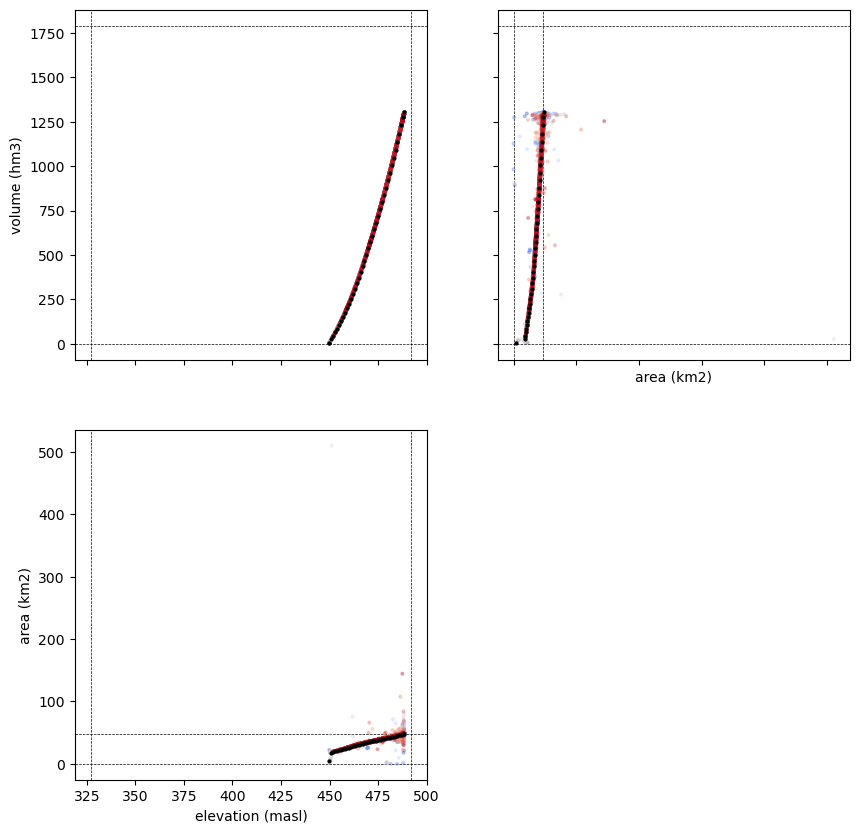

In [7]:
bin_size = 1
# clean outliers
if rho < 0.9:
    remove_outliers_kde(obs, 'elevation', 'storage', threshold_density=0.0001, inplace=True)

# compute bin medians
lookup_table = bin_data(obs.elevation, obs['storage'], agg='closest', bin_size=bin_size)

# add maximum and minimum capacity
#if lookup_table.index.max() < elev_masl and lookup_table.storage.max() < cap_mcm:
#    lookup_table.loc[elev_masl, 'storage'] = cap_mcm
#lookup_table.loc[z_min] = 0
#lookup_table.sort_index(inplace=True)

# estimate average area
#lookup_table['area'] = estimate_area_curve(lookup_table)
lookup_table['area'] = lookup_table.storage.diff() / lookup_table.elevation.diff()

fig, axes = plot_reservoir_curves(attrs=gdw.loc[grand_id], obs=obs)
for j, var_x in enumerate(['elevation', 'area']):
    for i, var_y in enumerate(['storage', 'area']):
        ax = axes[i,j]
        if i == 1 & j == 1:
            continue
        ax.scatter(
            lookup_table[var_x], 
            lookup_table[var_y], 
            c='k', 
            s=4,
            zorder=5,
            label='binned data'
        )

### `ReservoirCurve` class

Successfully saved ReservoirCurve to /home/chus-casado/Datos/reservoirs/ResOpsUS/v2.2/reservoir_curves/41.pkl


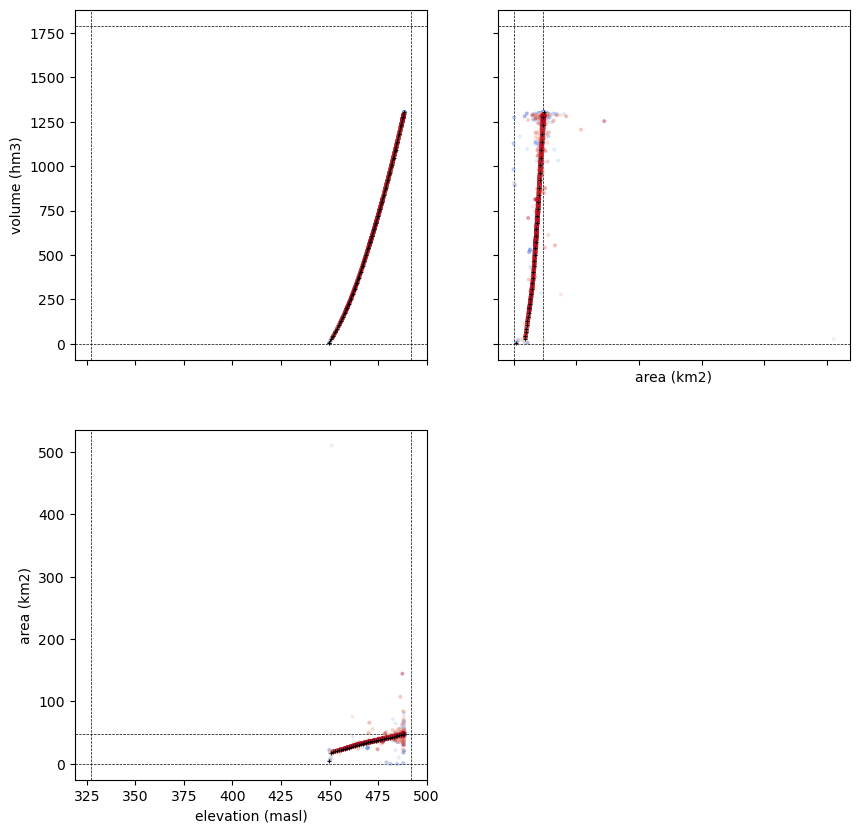

In [19]:
# initialize class
reservoir_curve = ReservoirCurve(lookup_table)
reservoir_curve.fit(method='pchip')

# plot
fig, axes = reservoir_curve.plot(attrs=gdw.loc[grand_id], obs=obs)

# export reservoir curve
pkl_file = path_resops / 'reservoir_curves' / f'{grand_id}.pkl'
save_curve(reservoir_curve, pkl_file)